In [28]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
from cellpose import io
from liams_funcs import *
from features import *

import pandas as pd

In [29]:
control_dir = '../control_images/'
penetramax_dir = '../penetramax_images/'

control_fnames = [control_dir + fname for fname in os.listdir(control_dir)]
penetramax_fnames = [penetramax_dir + fname for fname in os.listdir(penetramax_dir)]

In [30]:
fname1 = '../control_images/001_z26.png'
fname2 = '../penetramax_images/011_z57.png'

In [31]:
data = np.load('../segments/control/001_z26.png.npy')
image = io.imread('../control_images/001_z26.png')

reds, blues = image[:,:,0], image[:,:,2]
combined_cells, combined_nuclei = data[:,:,0], data[:,:,1]

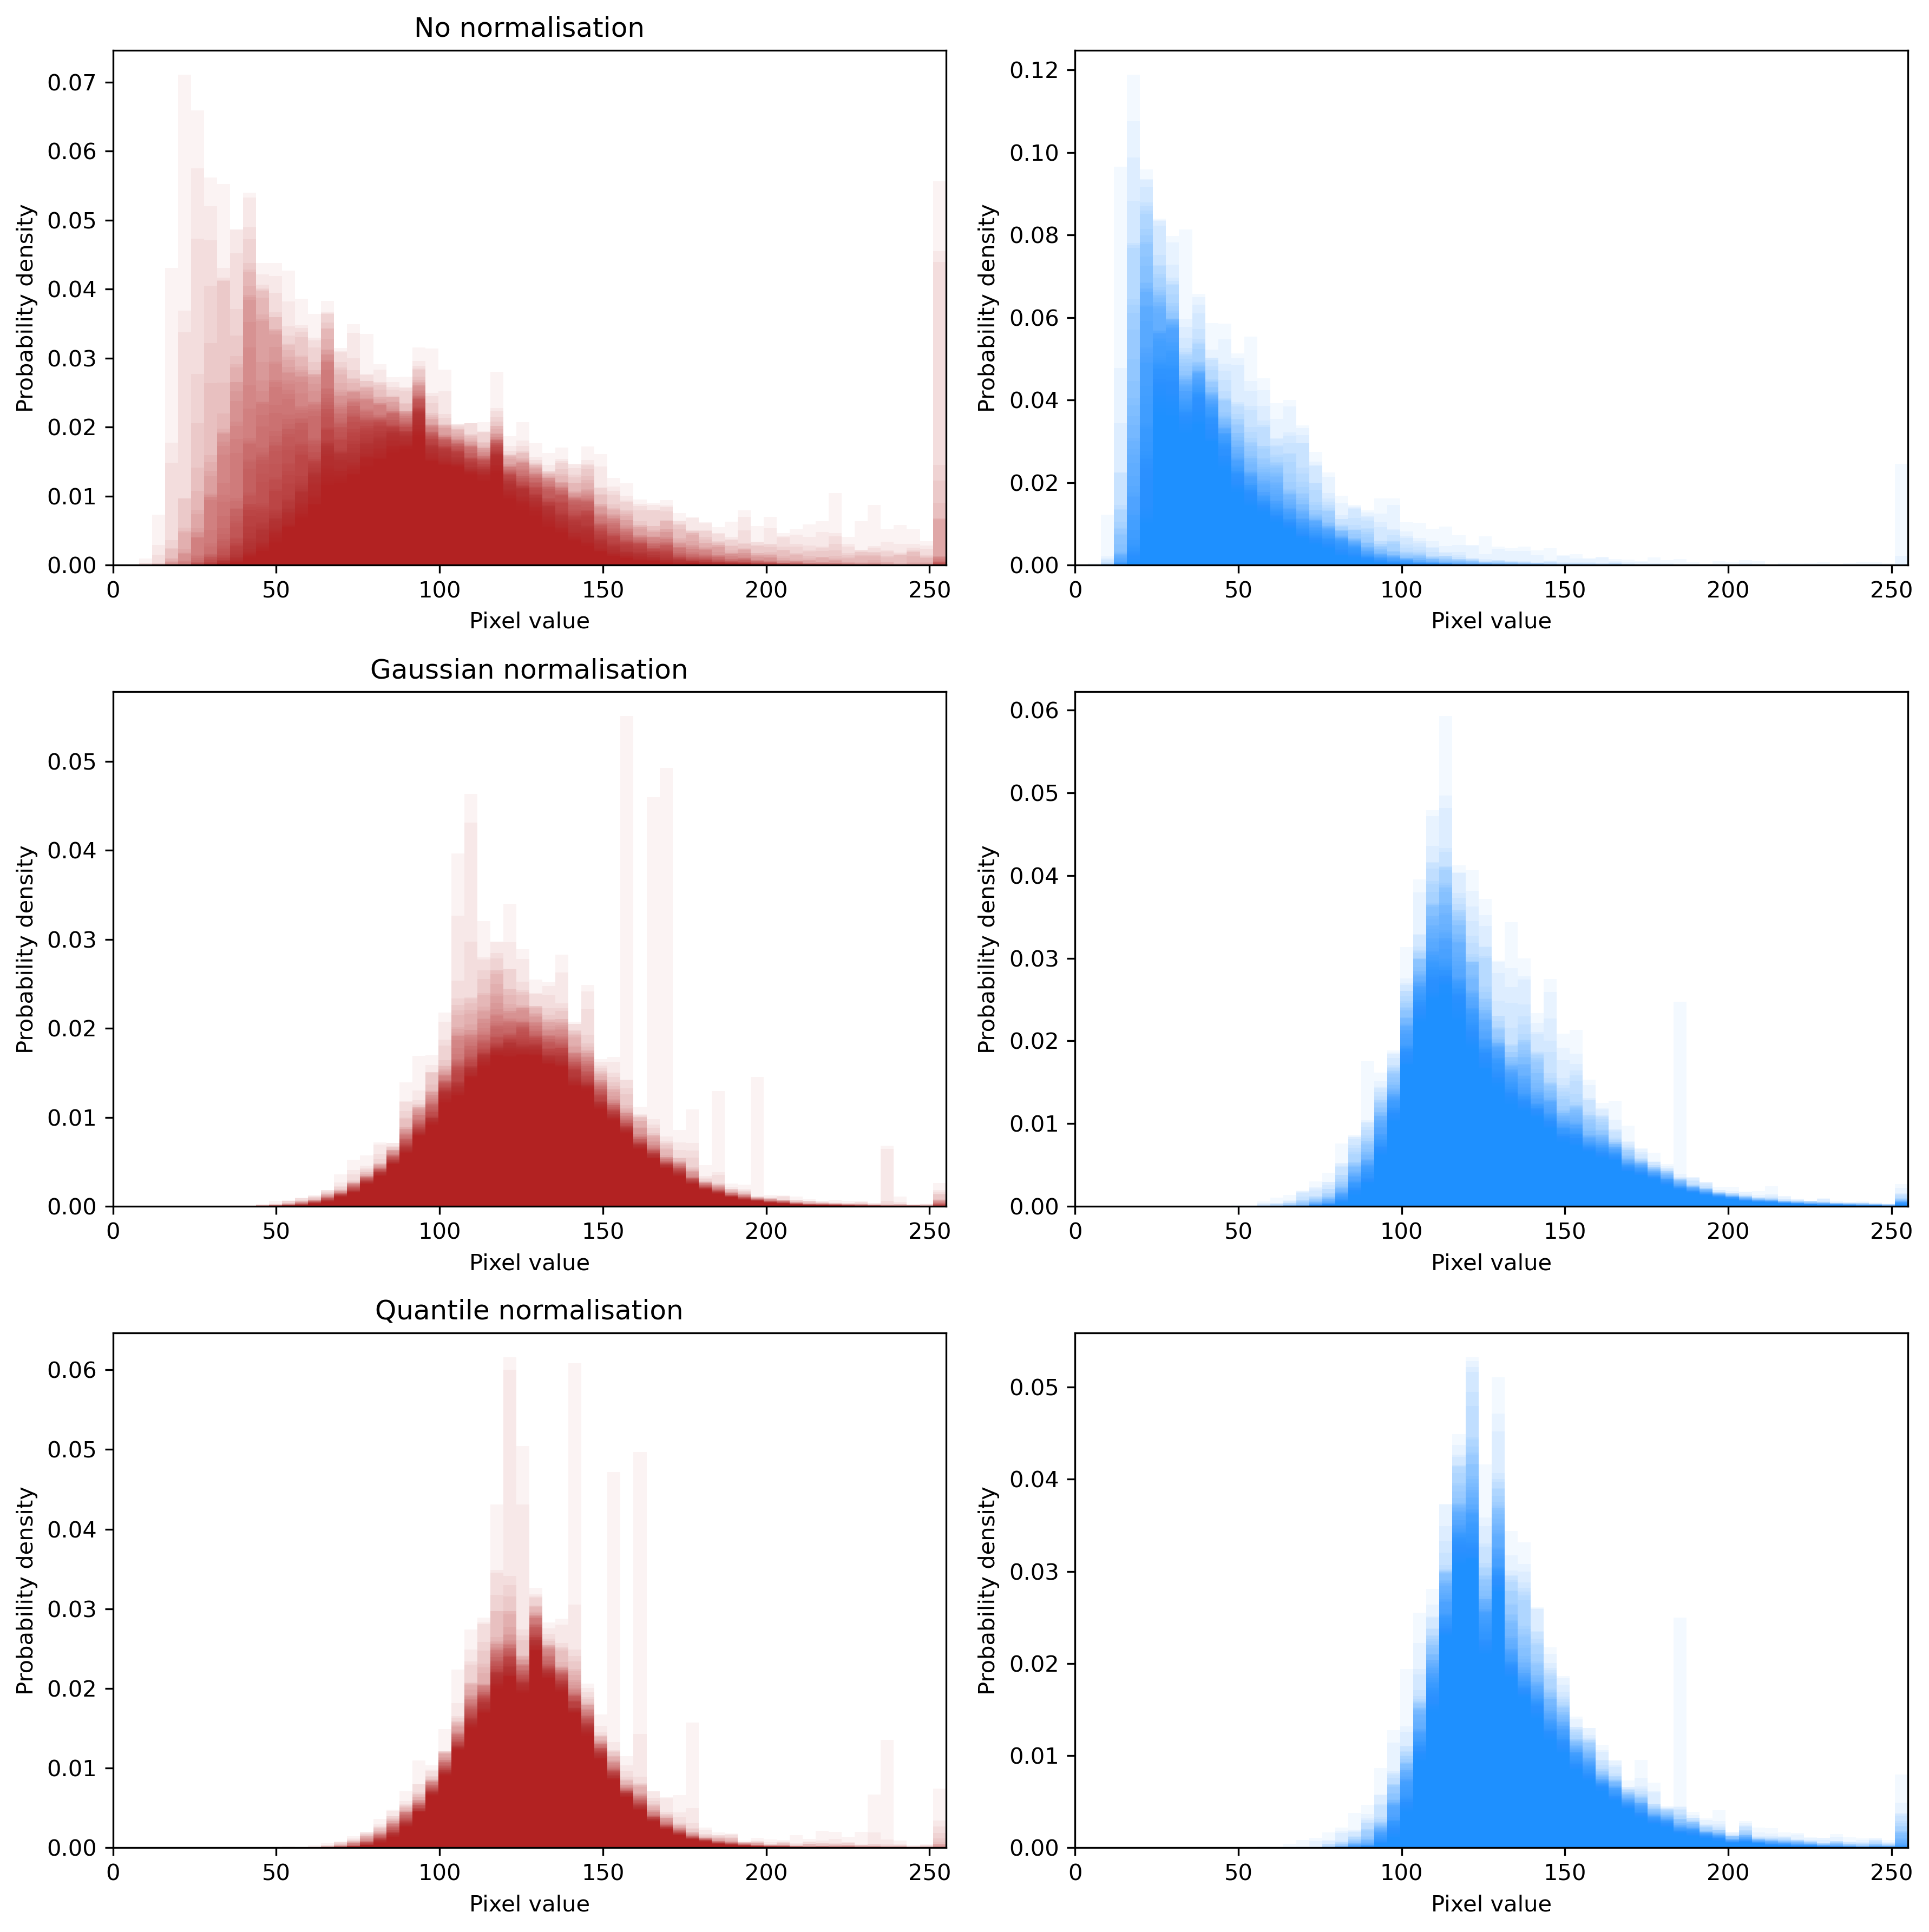

In [32]:
vals = np.arange(1, combined_nuclei.max()+1)
fig, axes = plt.subplots(3, 2, figsize=(12, 12), dpi=300)

for val in vals:
    mask = (combined_nuclei == val)
    red = reds[mask]
    blue = blues[mask]

    counts_red, edges = np.histogram(red, bins=64, range=(0,255), density=True)
    counts_blue, _ = np.histogram(blue, bins=64, range=(0,255), density=True)

    axes[0,0].stairs(counts_red, edges, fill=True, alpha=0.05, color='firebrick')
    axes[0,1].stairs(counts_blue, edges, fill=True, alpha=0.05, color='dodgerblue')

    counts_red, edges = np.histogram(ZtoRGB(gaussian_normalisation(red)), bins=64, range=(0, 255), density=True)
    counts_blue, _= np.histogram(ZtoRGB(gaussian_normalisation(blue)), bins=64, range=(0, 255), density=True)

    axes[1,0].stairs(counts_red, edges, fill=True, alpha=0.05, color='firebrick')
    axes[1,1].stairs(counts_blue, edges, fill=True, alpha=0.05, color='dodgerblue')

    counts_red, edges = np.histogram(ZtoRGB(quantile_normalisation(red)), bins=64, range=(0, 255), density=True)
    counts_blue, _ = np.histogram(ZtoRGB(quantile_normalisation(blue)), bins=64, range=(0, 255), density=True)

    axes[2,0].stairs(counts_red, edges, fill=True, alpha=0.05, color='firebrick')
    axes[2,1].stairs(counts_blue, edges, fill=True, alpha=0.05, color='dodgerblue')

for ax in axes.flatten():
    ax.set_ylim(0)
    ax.set_ylabel('Probability density')
    ax.set_xlabel('Pixel value')
    ax.set_xlim(0, 255)
    
axes[0,0].set_title('No normalisation'); axes[1,0].set_title('Gaussian normalisation'); axes[2,0].set_title('Quantile normalisation')

plt.tight_layout()
plt.savefig('../figures/spectrum_normalisations.png', dpi=300, bbox_inches='tight')
plt.show()

In [33]:
ms = []
for fname in tqdm(control_fnames):
    ms.append(Masks(fname.split('/')[-1], type='control'))
for fname in tqdm(penetramax_fnames):
    ms.append(Masks(fname.split('/')[-1], type='penetramax'))

100%|██████████| 10/10 [00:40<00:00,  4.00s/it]


In [34]:
dfs = []
for m in ms:
    dfs.append(m.getDataFrame())
df = pd.concat(dfs)

df.to_csv('features.csv', index=False)

In [35]:
X = df.drop('label', axis=1).to_numpy()
X_labels = df.drop('label', axis=1).columns

y = df['label'].to_numpy()

In [36]:
from sklearn.decomposition import PCA

X_pca = PCA(n_components=3).fit_transform(X)

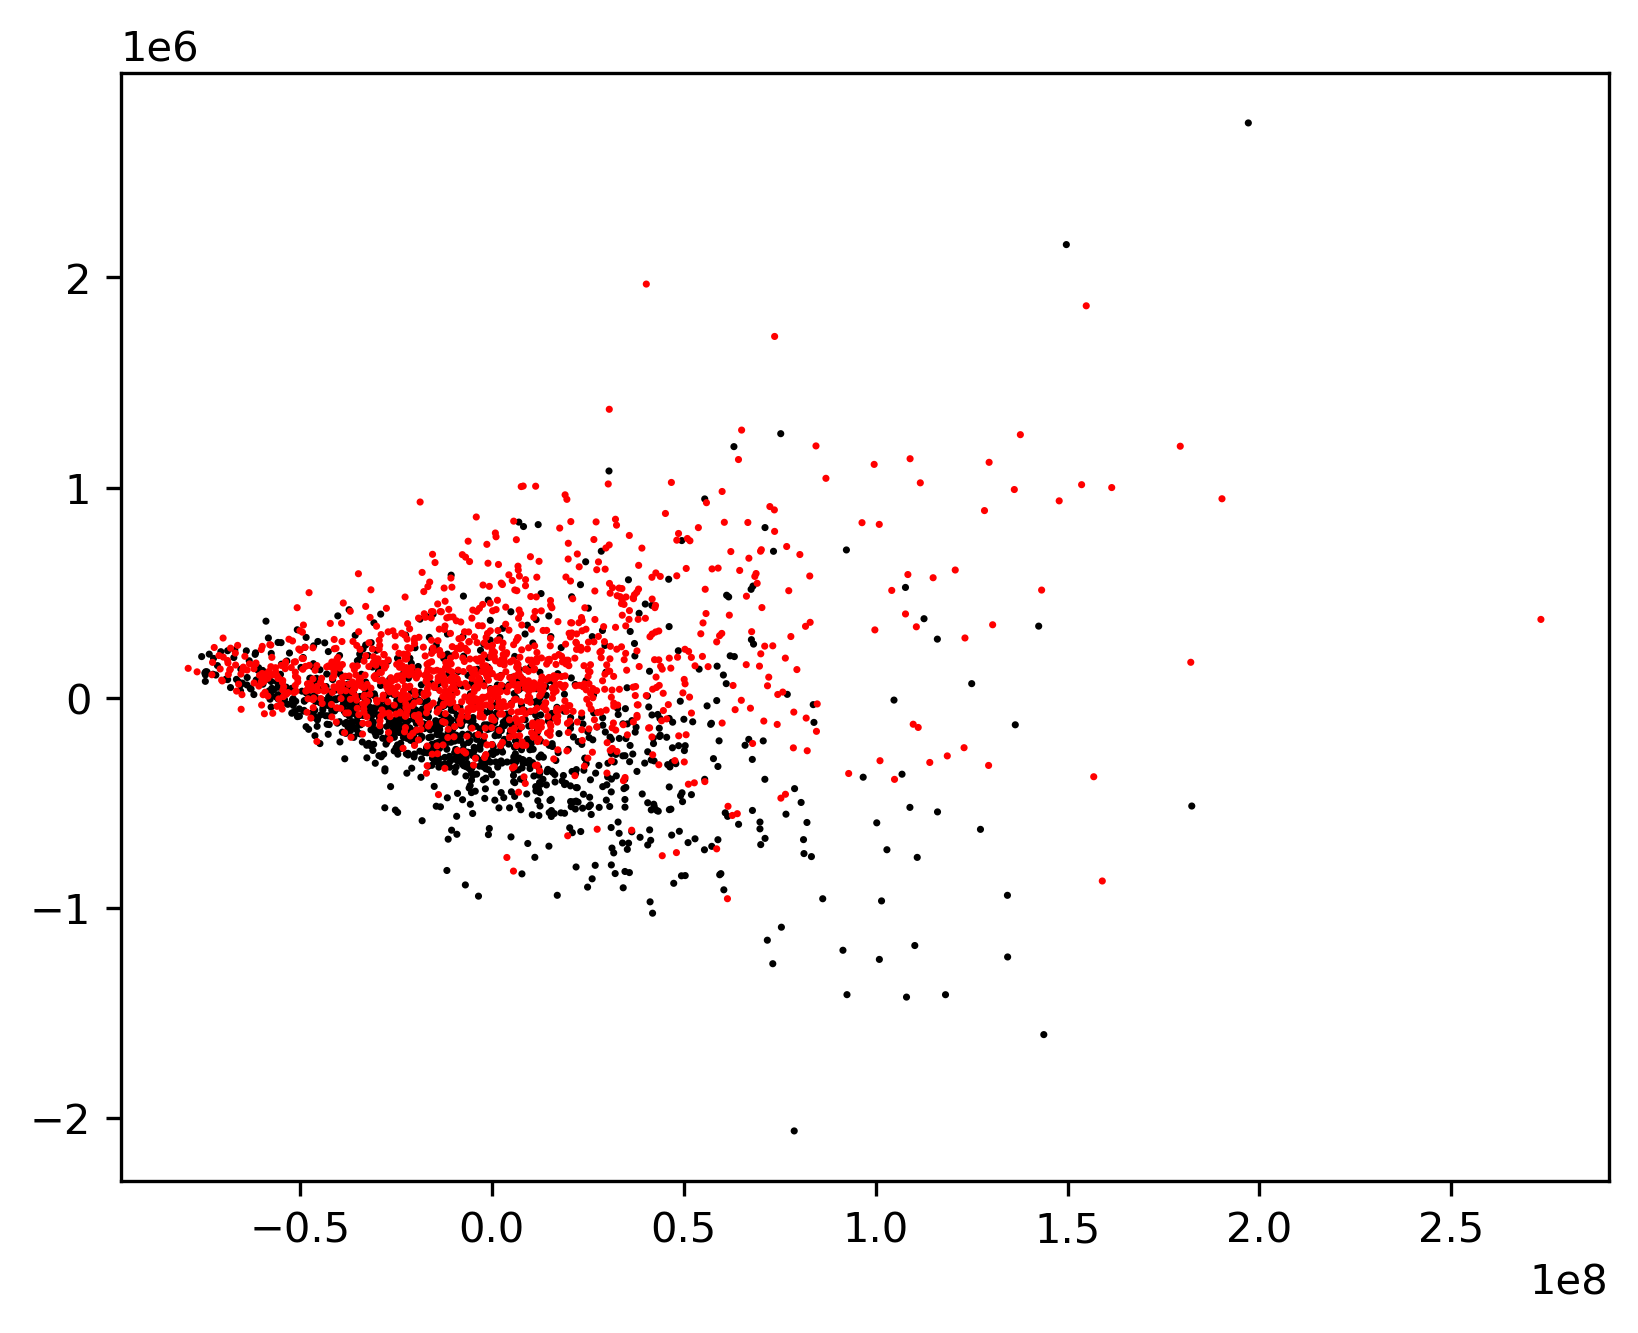

In [37]:
plt.figure(dpi=300)
plt.scatter(X_pca[:,0], X_pca[:,1], s=0.5, c=['k' if val==0 else 'r' for val in y])
plt.show()